<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [15]:
import gc
import math
import re
import os.path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from transformers import (
    BertModel,
    BertTokenizer,
    DistilBertModel,
    DistilBertTokenizer
)


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score
)

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss 

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [16]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    gc.collect()
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


In [17]:
df = pd.read_csv('datasets/toxic_comments.csv', index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [18]:
df = df.sample(1000, random_state=12345)

In [19]:
def clear_text(text, re):
    return " ".join(re.sub(r"[^a-zA-Z ']", ' ', text).split()).lower()
    
df['text'] = df['text'].progress_apply(clear_text, re=re)

display(df)

  0%|          | 0/1000 [00:00<?, ?it/s]

,text,toxic
109583,expert categorizers why is there no mention of...,0
105077,noise fart talk,1
82244,an indefinite block is appropriate even for a ...,0
18740,i don't understand why we have a screenshot of...,0
128310,hello some of the people places or things you ...,0
...,...,...
103747,your submission at articles for creation nova ...,0
15394,so they didn't see anything as there isn't any...,0
16408,re have a look all listed pages false garden m...,0
65763,dear helladios can you stop deleting my input ...,0


In [20]:
df['toxic'].value_counts()

0    890
1    110
Name: toxic, dtype: int64

In [21]:
word_len = df['text'].str.split().str.len()

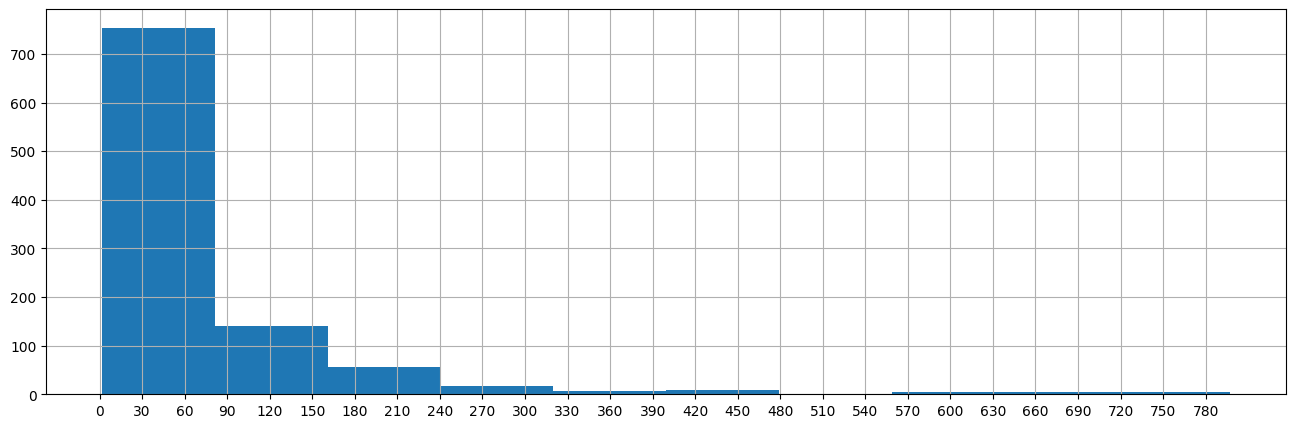

In [22]:
fig, ax = plt.subplots(figsize=(16,5))
plt.hist(word_len[word_len < 800])
plt.grid()
plt.xticks(range(0, 800, 30))
plt.show()
None

Судя по графику в большинстве текстов не более 240 слов. Установим максимальную длину предложений в tokenizer-е

In [23]:
CACHE_FEATURES = True
FEATURES_PATH = 'features.csv'
MAX_LENGTH = 256

In [24]:
def get_bert(device):
    # model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, 'bert-large-uncased')
    model_class, tokenizer_class, pretrained_weights = (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased')

    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    model.cuda(device)

    return model, tokenizer

def tokenize(text, tokenizer, max_length):
    return tokenizer.encode(
        text, 
        truncation=True, 
        max_length=max_length, 
        add_special_tokens=True
    )

# tokenize(df['text'].iloc[0], tokenizer)
# df['text'].apply(tokenize, tokenizer=tokenizer)

In [25]:
def get_padded_mask(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)

    padded = torch.LongTensor(padded)  
    attention_mask = torch.LongTensor(attention_mask)

    return padded, attention_mask

In [26]:
def get_features(model, padded, attention_mask, batch_size = 100):
    embeddings = []
    for i in tqdm(range(math.ceil(padded.shape[0] / batch_size))):
        padded_batch = padded[batch_size*i:batch_size*(i+1)].to(device)
        attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)].to(device)
        
        with torch.no_grad():
            batch_embeddings = model(padded_batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    return np.concatenate(embeddings)

In [27]:
model, tokenizer = get_bert(device)

if CACHE_FEATURES & os.path.isfile(FEATURES_PATH):
    features = np.loadtxt(FEATURES_PATH, delimiter=',')

    print('[Info] Features loaded from local cache')
else:
    tokenized = df['text'].parallel_apply(tokenize, tokenizer=tokenizer, max_length=MAX_LENGTH)

    padded, attention_mask = get_padded_mask(tokenized)

    features = get_features(model, padded, attention_mask)

    if CACHE_FEATURES:
        np.savetxt(FEATURES_PATH, features, delimiter=',')
        print('[Info] Features saved to local cache')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/10 [00:00<?, ?it/s]

[Info] Features saved to local cache


In [28]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Как видно из документации и вывода модели на экран на входе 512 нейронов, на выходе будет получено 768 фич

### Вывод:

Подготовлены данные для обучения, созданы embedding и релизовано сохранение, чтобы не ждать их формирования в дальнейшем.

Загружена предобучнная модель DistBert, использован GPU.

Чтобы ускорить токенизацию использован pandarallel для параллельной работы.

Установлено ограничение на длину предложения, чтобы сократить размер входных данных и ускорить работу модели.

## Обучение

In [29]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(8,5))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [30]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        # n_candidates="exhaust",
        # factor=5,
        n_jobs=-1,
        verbose=2
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_, hrs.best_params_, hrs.best_score_

In [45]:
labels = df['toxic']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=12345)

nm = NearMiss()
train_features, train_labels = nm.fit_resample(train_features, train_labels)

In [71]:
lr_pipe = Pipeline([
    ('clf', LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced'))
])

param_grid = {
    # 'clf__solver' : ['liblinear'],
    # 'clf__max_iter' : [2500, 5000],
    # 'clf__C': np.linspace(0.0001, 100, 20)

    'clf__solver' : ['liblinear'],
    'clf__max_iter' : [2500],
    'clf__C': 5.26325
}

lr_estimator, lr_best_params, lr_best_score = search_best_estimator(lr_pipe, param_grid, train_features, train_labels)

print('F1 cv', lr_best_score)
print(lr_best_params)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
F1 cv 0.7715520468962271
{'clf__C': 5.263252631578947, 'clf__max_iter': 2500, 'clf__solver': 'liblinear'}


In [68]:
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=12345))
])
param_grid = {
    # "clf__n_estimators": [i for i in range(100,600,100)],
    # "clf__max_depth": [i for i in range(5,15,5)],
    # "clf__min_samples_split":[i for i in range(2,4,2)],
    # "clf__min_samples_leaf": [2],

    "clf__n_estimators": [500],
    "clf__max_depth": [5],
    "clf__min_samples_split":[2],
    "clf__min_samples_leaf": [2],
}

rf_estimator, rf_best_params, rf_best_score = search_best_estimator(rf_pipe, param_grid, train_features, train_labels)

print('F1 cv:', rf_best_score)
print(rf_best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
F1 cv: 0.8144092064766494
{'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}


In [48]:
# cb_pipe = Pipeline([
#     ('clf', CatBoostClassifier(iterations=300, verbose=100))
# ])
# param_grid = {
#     "clf__learning_rate": [0.1] #[i/10 for i in range(1,3,1)] 
# }

# cb_estimator, cb_best_params, cb_best_score = search_best_estimator(cb_pipe, param_grid, train_features, train_labels)

# print('F1 cv:', cb_best_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.6284984	total: 34.9ms	remaining: 10.4s
100:	learn: 0.0109683	total: 3s	remaining: 5.92s
200:	learn: 0.0033634	total: 5.92s	remaining: 2.92s
299:	learn: 0.0019195	total: 8.88s	remaining: 0us
F1 cv: 0.7579365079365079


In [69]:
pipelines = pd.DataFrame(
    {
        "pipelines": [
            lr_pipe,
            rf_pipe,
            # cb_pipe
        ],
        "scores": [
            lr_best_score, 
            rf_best_score, 
            # cb_best_score
        ]
    }
).sort_values(by='scores', ascending=False)
display(pipelines)
pipeline = pipelines.iloc[0]['pipelines']

,pipelines,scores
1,"(RandomForestClassifier(max_depth=19, random_s...",0.814409
0,"(LogisticRegression(class_weight='balanced', r...",0.771552
2,(<catboost.core.CatBoostClassifier object at 0...,0.757937


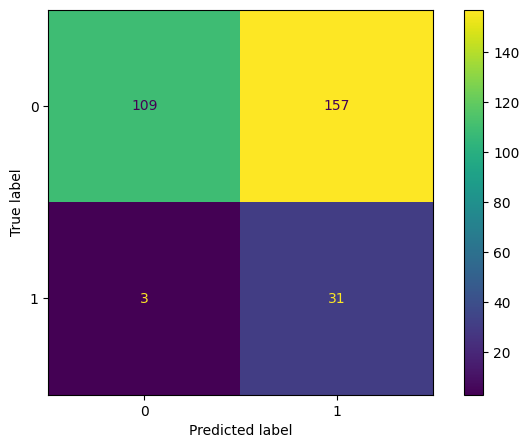

F1: 0.27927927927927926


In [70]:
pipeline.fit(train_features, train_labels)

predictions = pipeline.predict(test_features)

plot_confusion_matrix(test_labels, predictions, pipeline)
print('F1:', f1_score(test_labels, predictions))

In [51]:
clf = DummyClassifier(strategy='stratified', random_state=12345)
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)
print('F1:', f1_score(test_labels, clf.predict(test_features)))

F1: 0.20994475138121546


## Выводы

Сомневаюсь, что Bert или DistBert так плох, возможно я просто не умею его готовить. 

Если не убирать дисбаланс то результат выше, но я считаю что убирать его надо, т.к в какие-то периоды времени токсичных комментариев может быть больше.

Подбор гиперпараметров, я считаю, уже больше не даст

Лемматизацию и удаление стоп-слов в случае Bert-а говорят не делать, потому что он сам это понимает.

Переносы строк и мусорные символы я удалил.

Прошу рекомендаций куда копать и почему такая низкая точность.

Хочется использовать Bert, потому что TF-IDF уже применял в мастерской.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [-]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны